# Bestmöglichen Parameter für die Elo-Formel finden

## 5.1 Bedeutung der Elo-Zahl

### 5.1.1 Elo-Zahl vs. Gewinnrate

Der Elo-Wert ist die Spielstärke, die Gewinnrate eine Bilanz.

Analogie: Ein Boxer mit einer Bilanz von 50 Siegen und 0 Niederlagen ist nicht zwangsläufig besser als einer mit 45 Siegen und 5 Niederlagen. Wenn der erste nur gegen Amateure gekämpft hat und der zweite nur gegen Weltmeister, ist der zweite Boxer der weitaus stärkere.

### 5.1.2 Elo-Zahlen im Schach

| Perzentil | Elo (ab) | Titel                                  | Interpretation                        | Gespielte Partien in der DB  |
|-----------|----------|----------------------------------------|---------------------------------------|------------------------------|
| –         | 1000     | Amateur Klasse E                       | Frisch eingestiegen                   | –                            |
| –         | 1200     | Amateur Klasse D                       | die Regeln beherrschen                | –                            |
| 10%       | 1300     |                                        | Anfänger                              | –                            |
| –         | 1400     | Amateur Klasse C                       | Anfänger mit ersten Erfolgen          | –                            |
| 25%       | 1500     |                                        | Durchschnittlicher Vereinsspieler     | 1                            |
| –         | 1600     | Amateur Klasse B                       | gelegentliche Spieler                 | –                            |
| 50%       | 1700     |                                        | Solider, regelmäßiger Turnierspieler  | 3                            |
| –         | 1800     | Amateur Klasse A                       | Sehr guter Vereinsspieler             | –                            |
| 75%       | 1900     |                                        |                                       | 17                           |
| –         | 2000     |                                        |                                       | –                            |
| 90%       | 2100     | Meisteranwärter                        | Experte                               | 116                          |
| 95%       | 2200     | Meisterkandidat (Candidate Master, CM) |                                       | 324                          |
| –         | 2300     | FIDE-Meister (FM)                      |                                       | –                            |
| 99%       | 2400     | Internationaler Meister (IM)           |                                       | 1595                         |
| 99.9%     | 2500     | Großmeister (GM)                       | Die absolute Weltspitze               | 4992                         |

* Unterhalb 2000 Elo-Punkten gibt es keine offiziellen Titel, weshalb eine objektive Benennung der Spielstärke schwierig ist. Zur groben Einschätzung kann in Deutschland der DWZ-Schnitt der Amateurligen dienen. Die Deutsche Wertzahl DWZ ist zwar nicht dasselbe wie die international übliche ELO-Zahl, aber vergleichbar.

* Die Verteilung der FIDE-Elo-Werte (Stand 2024) im Schach sind sind annähernd normalverteilt:
    * Mittelwert: ~1650 - 1700
    * Standardabweichung: ~200 - 250

## 5.2 Daten erkunden

### 5.2.1 Wieviele Spieler haben wieviele Partien gespielt?

* Es gibt über 100.0000 Spieler in der Datenbank.
* Aber davon haben 25% nur einmal gespielt und die Hälfte max. nur dreimal.
* Auswertbar sind vielleicht 30% (100-70) mit einer Spielerfahrung von 10 Partien.
* 10% (100-90) haben mehr als 100 Partien gespielt, die vermutlich ausgezeichnete Spieler sind.

In [ ]:
#import numpy as np
#import pandas as pd
#import sqlite3
#import matplotlib.pyplot as plt
#import seaborn as sns

In [79]:
import math
from contextlib import nullcontext

# Anzahl der Partien pro Spieler abfragen

import pandas as pd
import sqlite3

DB_PATH = "../data/bsw/bsw.sqlite"
conn = sqlite3.connect(f"file:{DB_PATH}?mode=ro", uri=True)

query = """
    SELECT pr.player_id, count(*) AS num_games
    FROM players_rounds AS pr
    INNER JOIN rounds AS r ON pr.round_id = r.id
    INNER JOIN games AS g ON r.game_id = g.id
    WHERE g.error_code = 0 AND g.player_changed = 0 AND r.round_index = 0
    GROUP BY pr.player_id;
"""

player_exp_df = pd.read_sql_query(query, conn)
conn.close()

# Analyse der Verteilung
print("\nStatistische Verteilung der Spielerfahrung:")
player_exp_df['num_games'].describe(percentiles=[.1, .25, .50, .70, .75, .90, .95, .99, .999])


Statistische Verteilung der Spielerfahrung:


count    111107.000000
mean         77.790490
std         381.916331
min           1.000000
10%           1.000000
25%           1.000000
50%           3.000000
70%          11.000000
75%          17.000000
90%         116.000000
95%         324.000000
99%        1595.000000
99.9%      4991.866000
max       28211.000000
Name: num_games, dtype: float64

* count 111107.0: Das ist die Gesamtzahl der Spieler, für die die Statistik berechnet wurde. Deine SQL-Abfrage hat 111.107 einzigartige Spieler gefunden, die mindestens eine fehlerfreie Partie ohne Spielerwechsel gespielt haben. Das ist die 100%-Marke.
* 10% 1.0: Das bedeutet: 10% aller 111.107 Spieler haben genau 1 Partie gespielt.
* 25% 1.0: Das bedeutet: 25% aller Spieler (also ca. 27.777 Spieler) haben 1 oder weniger Partien gespielt. Da man nicht weniger als 1 spielen kann, heißt das: 25% der Spieler haben genau 1 Partie gespielt. (Die Tatsache, dass der Wert bei 10% und 25% gleich ist, zeigt, wie viele Spieler nach nur einem Spiel aufhören).
* 50% 3.0 (der Median): Das bedeutet: 50% aller Spieler (die "untere Hälfte", ca. 55.554 Spieler) haben 3 oder weniger Partien gespielt. Die andere Hälfte hat mehr als 3 Partien gespielt.
* 70% 11.0: 70% aller Spieler haben 11 oder weniger Partien gespielt.
* 90% 116.0: 90% aller Spieler haben 116 oder weniger Partien gespielt. Umgekehrt bedeutet das: Nur die Top 10% der Spieler haben mehr als 116 Partien gespielt. Das sind deine "Vielspieler".
* 99% 1595.0: Nur 1% der Spieler (die absolute Elite, ca. 1.111 Spieler) haben mehr als 1595 Partien gespielt.

### 5.2.2 Wieviele Partien wurden von erfahrenen Spielern gespielt?

* Die Datenqualität für erfahrene Spieler ist exzellent: Pool von über 1 Million Partien (die Summe der Balken ab "201-500"), die ausschließlich unter erfahrenen bis sehr erfahrenen Spielern stattgefunden haben.

* Schwellenwert für "gute Spieler": Ein sinnvoller Schwellenwert für "gute Spieler" könnte bei mindestens 100 oder sogar 200 Partien liegen. Damit schließe ich die Gelegenheitsspieler aus und fokussiere mich auf den Kern der aktiven Community, wo das Spiel "ernsthafter" gespielt.

In [14]:
%%sql
SELECT count(*) AS num_games FROM games WHERE error_code = 0 AND player_changed = 0;

,num_games
0,2160767


In [5]:
%%sql
SELECT min_player_num_games, COUNT(*) AS num_games
FROM (
    SELECT g.id AS game_id, MIN(p.num_games) AS min_player_num_games
    FROM games AS g
    INNER JOIN rounds AS r ON g.id = r.game_id
    INNER JOIN players_rounds AS pr ON r.id = pr.round_id
    INNER JOIN players AS p  ON pr.player_id = p.id
    WHERE g.error_code = 0 AND g.player_changed = 0 AND r.round_index = 0
    GROUP BY g.id
)
GROUP BY min_player_num_games;

,min_player_num_games,num_games
0,1,36039
1,2,21502
2,3,16640
3,4,13958
4,5,12819
...,...,...
2322,8045,30
2323,8061,4
2324,8564,3
2325,8846,2


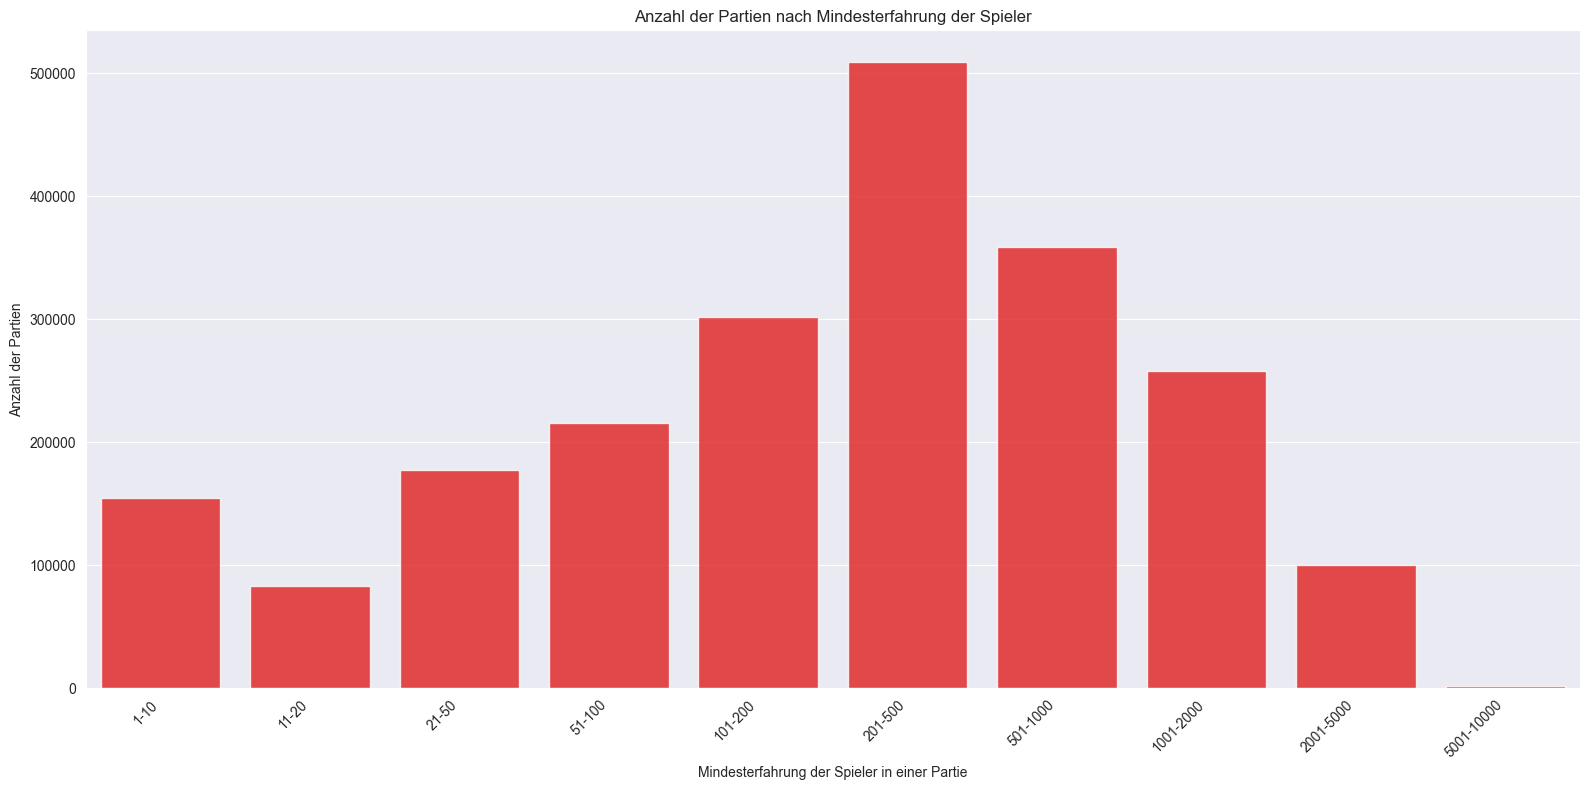

In [6]:
# Bardiagramm

import matplotlib.pyplot as plt
import seaborn as sns
#import numpy as np

# Definiere die Bins (Gruppen) für die x-Achse.
# Wir verwenden eine logarithmische Skala für die Bins, da die Daten so verteilt sind
# bins = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
bins = [0, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
labels = [f'{bins[i]+1}-{bins[i+1]}' for i in range(len(bins)-1)]

# Füge eine neue Spalte zum DataFrame hinzu, die angibt, zu welchem Bin jeder Wert gehört
df_sql1['experience_bin'] = pd.cut(df_sql1['min_player_num_games'], bins=bins, labels=labels, right=True)

# Gruppiere nach diesen Bins und summiere die Anzahl der Partien
binned_df = df_sql1.groupby('experience_bin', observed=False)['num_games'].sum().reset_index()

# Erzeuge das Balkendiagramm
plt.figure(figsize=(16, 8))
sns.barplot(x='experience_bin', y='num_games', data=binned_df, color='red', alpha=0.8)

# Achsentitel und Diagrammtitel
plt.xlabel('Mindesterfahrung der Spieler in einer Partie')
plt.ylabel('Anzahl der Partien')
plt.title('Anzahl der Partien nach Mindesterfahrung der Spieler')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Interpretation**

* Balken "1-10" (ca. 150.000 Partien): Es gibt eine beträchtliche Anzahl von Partien, in denen mindestens ein Neuling dabei ist. Das sind die typischen "Schnupperrunden" oder Runden, in denen ein erfahrener Spieler einen Freund mitbringt.

* Balken "11-20" (deutlicher Abfall auf < 100.000 Partien): Das ist der "Filter". Viele Spieler, die nur mal reinschnuppern, hören nach wenigen Partien wieder auf. Spieler mit 11-20 Partien sind in einer Übergangsphase – sie sind keine blutigen Anfänger mehr, aber auch noch keine Veteranen. Es gibt relativ wenige Partien, bei denen ein Spieler aus genau dieser Gruppe der Unerfahrenste ist.

* Der überraschende Anstieg ("21-50" bis "101-200"): Hier wird es spannend. Die Anzahl der Partien steigt wieder stark an. Das bedeutet: Partien, bei denen der unerfahrenste Spieler schon 50 oder 100 Spiele hinter sich hat, sind häufiger als Runden mit Fast-Anfängern. Das deutet auf eine starke "Stammspieler"-Kultur hin.

* Der Gipfel (Peak) bei "201-500" (über 500.000 Partien): Das ist die wichtigste Erkenntnis. Die mit Abstand größte Gruppe von Partien sind solche, bei denen alle vier Spieler am Tisch bereits mindestens 201 Partien gespielt haben. Das ist das Herz der Tichu-Community. Es sind keine gemischten Runden mehr, sondern Runden unter erfahrenen Spielern. Dies könnte durch Freundeslisten, Turniere oder einfach durch die Tatsache erklärt werden, dass erfahrene Spieler bevorzugt mit anderen erfahrenen Spielern zusammenspielen.

* Der Abfall danach ("501-1000" und folgende): Nach dem Peak beginnt der erwartete "Long Tail". Es wird zunehmend seltener, vier Spieler zu finden, die alle eine Mindesterfahrung von 500, 1000 oder mehr Partien haben. Aber selbst in der Kategorie "1001-2000" gibt es immer noch eine riesige Anzahl von über 250.000 Partien.

## 5.3 Automatische Optimierung der Elo-Parameter

Ziel ist es, die bestmöglichen Parameter für das Elo-System zu finden, die den Fehler zwischen der vorausgesagten Gewinnwahrscheinlichkeit und dem tatsächlichen Ergebnis minimiert. Das ist ein klassisches Optimierungsproblem.

Die Formel für den Erwartungswert e in der Elo-Berechnung (e20 = 1 / (1 + 10^...)) gibt eine Wahrscheinlichkeit (einen Wert zwischen 0 und 1) zurück. Das tatsächliche Ergebnis s wird ebenfalls auf diesem Bereich abgebildet (1 für Sieg, 0.5 für Unentschieden, 0 für Niederlage).

Der **mittlere quadratische Fehler (Mean Squared Error; MSE = (s - e)²)** ist die Standard-Verlustfunktion (Loss Function) für die Messung des Fehlers zwischen einer vorhergesagten (erwarteten) Wahrscheinlichkeit e und einem binären/kategorischen (tatsächlichen) Ergebnis s.

MSE als Fehlerfunktion ist hier also genau die richtige Wahl für eine automatisierte Optimierung.

**Ergebnis der automatischen Optimierung:**

Ich habe 2. Durchläufe mit jeweils eine eigene Stichproben durchgeführt. Beides mal haben wurden nicht alle Parameter geändert.

**Vermutlich steckt der Optimierer im lokalen Minimum fest!**

* Hier ist die Formel mit den gefundenen optimierten Parametern:

```python
def update_elo(...):
    # ...
    e20 = 1.0 / (1.0 + 10 ** ((r31 - r20) / 402.0))  # orig. divisor: 400.0
    # ...

def get_k_factor(num_games: int, max_elo: float) -> float:
    if num_games < 30:  # == orig.
        return 23.1  # orig.: 40.0
    elif max_elo < 2400: # == orig.
        return 13.7  # orig.: 20.0
    else:
        return 10.0  # == orig.

start_elo: 1500.0  # == orig.
```

* Finaler MSE: 0.237795


In [98]:
# Daten abfragen (zufällige Stichprobe)

import sqlite3
import numpy as np
import pandas as pd

DB_PATH = "../data/bsw/bsw.sqlite"
conn = sqlite3.connect(f"file:{DB_PATH}?mode=ro", uri=True)

# Nimm eine repräsentative Stichprobe von Partien
SAMPLE_SIZE = 250000

# Die SQL-Abfrage liefert alle Partien, bei denen ALLE Spieler die festgelegte Mindesterfahrung haben.
# Die Subquery liefert eine zufällige Stichprobe gültiger Game-IDs zurück
query = f"""
    SELECT
        g.id AS game_id,
        pr.player_id,
        pr.player_index,
        g.winner_team
    FROM games AS g
    INNER JOIN rounds AS r ON g.id = r.game_id
    INNER JOIN players_rounds AS pr ON r.id = pr.round_id
    INNER JOIN (
        SELECT id
        FROM games
        WHERE error_code = 0 AND player_changed = 0
        ORDER BY RANDOM()
        LIMIT {SAMPLE_SIZE}
    ) AS random_games ON g.id = random_games.id
    WHERE r.round_index = 0
    ORDER BY g.id, pr.player_index
"""

# Das Dataframe ist chronologisch und sortiert (nach Partien und pro Partie nach Spielerindex) .
df_samples = pd.read_sql_query(query, conn)

conn.close()

print(f"{len(df_samples)} Datenpunkte aus {df_samples['game_id'].nunique()} Partien geladen.")


1000000 Datenpunkte aus 250000 Partien geladen.


In [4]:
# Simulation (Elo-Historie durchlaufen und Fehler berechnen)

from typing import List, Tuple, Dict
from tqdm import tqdm

# Die Parameter, die zu optimieren sind

elo_params = {
    'divisor': 400.0,
    'k_newbie': 40.0,
    'k_standard': 20.0,
    'k_expert': 10.0,
    'newbie_threshold_games': 30,
    'expert_threshold_elo': 2400.0,
    'start_elo': 1500.0,
}

# Zielfunktion (Elo-Funktion)

def get_k_factor(player_stats: Dict[str, float], params: Dict[str, float]) -> float:
    """Berechnet den K-Faktor für einen einzelnen Spieler."""
    if player_stats["num_games"] < params['newbie_threshold_games']:
        return params['k_newbie']  # orig.: 40
    elif player_stats["max_elo"] < params['expert_threshold_elo']:
        return params['k_standard']  # orig.: 20
    else:
        return params['k_expert']  # orig.: 10

def update_elo(stats: List[Dict[str, float]], winner_team: int, params: Dict[str, float]) -> Tuple[Tuple[float, float, float, float], float]:
    """Berechnet die neuen Elo-Werte und den MSE für eine Partie."""

    # Team-Ratings berechnen
    elo_p0, elo_p1, elo_p2, elo_p3 = stats[0]["elo"], stats[1]["elo"], stats[2]["elo"], stats[3]["elo"]
    r20 = (elo_p0 + elo_p2) / 2.0  # Mittelwert der Ratings von Team 20
    r31 = (elo_p1 + elo_p3) / 2.0  # Mittelwert der Ratings von Team 31

    # Erwartungswert und tatsächliches Ergebnis
    e20 = 1.0 / (1.0 + 10 ** ((r31 - r20) / params['divisor']))  # erwartete Gewinnwahrscheinlichkeit für Team 20
    s20 = 1.0 if winner_team == 20 else 0.0 if winner_team == 31 else 0.5  # tatsächlicher Gewinn für Team 20

    # Abweichung und Fehler
    diff20 = s20 - e20  # Abweichung für Team 20
    diff31 = -diff20  # Abweichung für Team 31
    mse = diff20 ** 2  # der mittlere quadratische Fehler

    # K-Faktoren für jeden Spieler
    k_factors = [get_k_factor(s, params) for s in stats]

    # Neue Elo-Zahlen berechnen
    new_ratings = (
        elo_p0 + k_factors[0] * diff20,
        elo_p1 + k_factors[1] * diff31,
        elo_p2 + k_factors[2] * diff20,
        elo_p3 + k_factors[3] * diff31,
    )

    return new_ratings, mse

# Simulationsfunktion.

# Diese Funktion nimmt einen Satz von Parametern, simuliert die gesamte Elo-Historie und gibt den Gesamtfehler zurück.
def simulate_elo_and_calculate_error(params, games_iter, total_games) -> float:
    player_data = {}
    squared_errors = []

    progress_bar = tqdm(games_iter, total=total_games, unit=" Partien", desc="Simuliere Daten")

    for game_id, game_df in progress_bar:
        player_ids = game_df['player_id'].tolist()
        winner_team = game_df['winner_team'].iloc[0]

        # *** SICHERHEITSPRÜFUNG ***
        assert(len(player_ids) == 4)

        # Initialisiere neue Spieler
        for pid in player_ids:
            if pid not in player_data:
                player_data[pid] = {
                    'num_games': 0,
                    'max_elo': params['start_elo'],
                    'elo': params['start_elo'],
                }

        # Neue Elo-Werte und den Fehler für diese Partie berechnen
        stats = [player_data[pid] for pid in player_ids]
        new_ratings, mse = update_elo(stats, winner_team, params)

        # Fehler speichern
        squared_errors.append(mse)

        # Spielerstatistik aktualisieren
        for i, pid in enumerate(player_ids):
            player_data[pid]['num_games'] += 1
            player_data[pid]['max_elo'] = max(player_data[pid]['max_elo'], new_ratings[i])
            player_data[pid]['elo'] = new_ratings[i]

    prediction_error = np.mean(squared_errors) if squared_errors else float('inf')
    return prediction_error

In [15]:
# Optimierer

from scipy.optimize import minimize  # gradienten-basierter Optimierer

def objective_function(param_array):
    """Funktion, die der Optimierer minimieren soll"""

    # Wandle das Array vom Optimierer zurück in unser Parameter-Dict um
    params = {
        'divisor': param_array[0],
        'k_newbie': param_array[1],
        'k_standard': param_array[2],
        'k_expert': param_array[3],
        'newbie_threshold_games': int(round(param_array[4])),  # Sicherstellen, dass es ein Integer ist
        'expert_threshold_elo': param_array[5],
        'start_elo': param_array[6],
    }

    # Dieser Iterator liefert für jede game_id ein DataFrame mit 4 Zeilen, eine für jeden Spieler und das Ergebnis.
    # Wichtig: Der Iterator wird bei jedem Aufruf verbraucht. Wir müssen ihn für jeden Lauf neu erstellen.
    games_iter = df_samples.groupby('game_id')
    total_games = df_samples['game_id'].nunique()

    # Führe die teure Simulation aus
    error = simulate_elo_and_calculate_error(params, games_iter, total_games)

    print(f"Parameter: {params} -> MSE: {error:.6f}")
    return error

# Startwerte und Grenzen für die Parameter
#               divisor     k_newbie k_standard k_expert th_games   th_elo        start_elo
#initial_guess = [400.0,      40.0,     20.0,     10.0,    30,        2400,         1500]
#bounds =        [(350, 450), (20, 50), (10, 30), (5, 15), (10, 50), (1200, 2500), (1000, 1600)]

# 2. Durchlauf mit neuer Stichprobe
#               divisor     k_newbie k_standard k_expert th_games   th_elo        start_elo
initial_guess = [402.0,      23.1,     13.7,     10.0,    30,        2400,         1500]  # bestes Ergebnis aus 1. Durchlauf
bounds =        [(399, 405), (20, 26), (10, 17), (7, 13), (27, 33), (2370, 2430), (1470, 1530)] # eingeschränkter Bereich

# Starte die Optimierung
result = minimize(objective_function, initial_guess, bounds=bounds, method='L-BFGS-B')  # , options={'maxiter': 50})

print("\n--- Optimale Parameter gefunden ---")
final_params = {
    'divisor': float(result.x[0]),
    'k_newbie': float(result.x[1]),
    'k_standard': float(result.x[2]),
    'k_expert': float(result.x[3]),
    'newbie_threshold_games': int(round(result.x[4])),
    'expert_threshold_elo': float(result.x[5]),
    'start_elo': float(result.x[6]),
}
print(final_params)
print(f"Finaler MSE: {result.fun:.6f}")


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19454.04 Partien/s]


Parameter: {'divisor': np.float64(402.0), 'k_newbie': np.float64(23.1), 'k_standard': np.float64(13.7), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237795


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 19101.85 Partien/s]


Parameter: {'divisor': np.float64(402.00000001), 'k_newbie': np.float64(23.1), 'k_standard': np.float64(13.7), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237795


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 18741.58 Partien/s]


Parameter: {'divisor': np.float64(402.0), 'k_newbie': np.float64(23.100000010000002), 'k_standard': np.float64(13.7), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237795


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19538.80 Partien/s]


Parameter: {'divisor': np.float64(402.0), 'k_newbie': np.float64(23.1), 'k_standard': np.float64(13.70000001), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237795


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19857.47 Partien/s]


Parameter: {'divisor': np.float64(402.0), 'k_newbie': np.float64(23.1), 'k_standard': np.float64(13.7), 'k_expert': np.float64(10.00000001), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237795


Simuliere Daten: 100%|██████████| 250000/250000 [00:13<00:00, 19170.05 Partien/s]


Parameter: {'divisor': np.float64(402.0), 'k_newbie': np.float64(23.1), 'k_standard': np.float64(13.7), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.0)} -> MSE: 0.237795


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19927.32 Partien/s]


Parameter: {'divisor': np.float64(402.0), 'k_newbie': np.float64(23.1), 'k_standard': np.float64(13.7), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.00000001), 'start_elo': np.float64(1500.0)} -> MSE: 0.237795


Simuliere Daten: 100%|██████████| 250000/250000 [00:12<00:00, 19661.03 Partien/s]


Parameter: {'divisor': np.float64(402.0), 'k_newbie': np.float64(23.1), 'k_standard': np.float64(13.7), 'k_expert': np.float64(10.0), 'newbie_threshold_games': 30, 'expert_threshold_elo': np.float64(2400.0), 'start_elo': np.float64(1500.00000001)} -> MSE: 0.237795

--- Optimale Parameter gefunden ---
{'divisor': 402.0, 'k_newbie': 23.1, 'k_standard': 13.7, 'k_expert': 10.0, 'newbie_threshold_games': 30, 'expert_threshold_elo': 2400.0, 'start_elo': 1500.0}
Finaler MSE: 0.237795


## 5.5 Manuelle Optimierung der Elo-Parameter

Ziel ist es jetzt, eine stabile Entwicklung der Elo-Zahl in Abhängigkeit der Erfahrung zu modellieren, in der Größenordnung und somit Interpretation vergleichbar wie die Elo-Zahl für Schach.

In [83]:
# Daten abfragen (alle fehlerfreien Partien ohne Spielerwechsel)

import sqlite3
import numpy as np
import pandas as pd

DB_PATH = "../data/bsw/bsw.sqlite"
conn = sqlite3.connect(f"file:{DB_PATH}?mode=ro", uri=True)

# Die SQL-Abfrage liefert alle Partien, bei denen ALLE Spieler die festgelegte Mindesterfahrung haben.
query = f"""
    SELECT
        g.id AS game_id,
        pr.player_id,
        pr.player_index,
        g.winner_team
    FROM games AS g
    INNER JOIN rounds AS r ON g.id = r.game_id
    INNER JOIN players_rounds AS pr ON r.id = pr.round_id
    WHERE g.error_code = 0 AND g.player_changed = 0 AND r.round_index = 0
    ORDER BY g.id, pr.player_index
"""

# Das Dataframe ist chronologisch und sortiert (nach Partien und pro Partie nach Spielerindex) .
df_all = pd.read_sql_query(query, conn)

conn.close()

print(f"{len(df_all)} Datenpunkte aus {df_all['game_id'].nunique()} Partien geladen.")


8643068 Datenpunkte aus 2160767 Partien geladen.


In [102]:
del aggregated_df_optimale
del params_optimale
del plot_df_optimale
del timeseries_df_optimale

In [131]:
# Aufzeichnungsfunktion
# Für jeden Spieler werden die gespielten Partien durchlaufen und die Entwicklung der Elo-Zahl aufgezeichnet.

#from typing import List, Tuple, Dict
from tqdm import tqdm

def generate_timeseries(params, all_games_df):
    player_data = {}
    timeseries = []

    total_games = all_games_df['game_id'].nunique()
    games_iter = all_games_df.groupby('game_id')

    progress_bar = tqdm(games_iter, total=total_games, unit=" Partien", desc="Simuliere Spielverlauf")

    for game_id, game_df in progress_bar:
        player_ids = game_df['player_id'].tolist()
        winner_team = game_df['winner_team'].iloc[0]

        # Spieler initialisieren
        for pid in player_ids:
            if pid not in player_data:
                player_data[pid] = {
                    'num_games': 0, 'max_elo': params['start_elo'], 'elo': params['start_elo'], 'num_wins': 0
                }

        # Elo aktualisieren
        stats = [player_data[pid] for pid in player_ids]
        new_ratings, _ = update_elo(stats, winner_team, params)

        # Statistik aktualisieren UND Snapshot aufzeichnen
        for i, pid in enumerate(player_ids):
            # 1. Statistik aktualisieren
            player_data[pid]['num_games'] += 1
            player_data[pid]['elo'] = new_ratings[i]
            player_data[pid]['max_elo'] = max(player_data[pid]['max_elo'], new_ratings[i])

            is_winner = (game_df.iloc[i]['player_index'] in [0, 2] and winner_team == 20) or \
                        (game_df.iloc[i]['player_index'] in [1, 3] and winner_team == 31)
            if is_winner:
                player_data[pid]['num_wins'] += 1

            # 2. Snapshot der Werte NACH diesem Spiel aufzeichnen
            current_win_rate = player_data[pid]['num_wins'] / player_data[pid]['num_games']

            timeseries.append({
                'player_id': pid,
                'num_games': player_data[pid]['num_games'],
                'elo_value': player_data[pid]['elo'],
                'win_rate': current_win_rate
            })

    timeseries_df = pd.DataFrame(timeseries)
    #display(timeseries_df.head())

    return timeseries_df

In [130]:
# Daten nach der Anzahl der gespielten Partien gruppieren und Durchschnittswerte berechnen

def aggregate_timeseries(timeseries_df):
    aggregated_df = timeseries_df.groupby('num_games').agg(
        player_count=('player_id', 'count'),
        avg_win_rate=('win_rate', 'mean'),
        avg_elo_value=('elo_value', 'mean')
    ).reset_index()

    #display(aggregated_df.head())

    return aggregated_df

In [126]:
# Plotter

import matplotlib.pyplot as plt
import seaborn as sns

def plot_timeseries(aggregated_df, title):
    # Beschränke die Daten auf den zu plottenden Bereich für bessere Lesbarkeit
    MAX_GAMES_TO_PLOT = 6000
    plot_df = aggregated_df[aggregated_df['num_games'] <= MAX_GAMES_TO_PLOT].copy()

    # Matplotlib Stil setzen
    sns.set_theme(style="whitegrid")

    # Erstelle eine Figur mit zwei untereinander liegenden Subplots
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(16, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle('Entwicklung von Elo und Gewinnrate nach gespielten Partien', fontsize=18)

    # Plot 1: Elo und Win Rate (obere Grafik)
    color1 = 'tab:blue'
    ax1.set_ylabel('Elo-Wert', color=color1, fontsize=12)
    sns.lineplot(x='num_games', y='avg_elo_value', data=plot_df, ax=ax1, color=color1, alpha=0.3, label=f'Elo ({title})')
    ax1.axhline(1500, color='gray', linestyle=':', label='Start-Elo (1500)')
    ax1.tick_params(axis='y', labelcolor=color1)

    window_size = 100
    plot_df['elo_moving_avg'] = plot_df['avg_elo_value'].rolling(window=window_size, min_periods=1).mean()
    sns.lineplot(x='num_games', y='elo_moving_avg', data=plot_df, ax=ax1, color='blue', linewidth=2.5, label=f'Elo ({title}, geglättet)')

    # Rechte Y-Achse für Win Rate
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel('Gewinnrate', color=color2, fontsize=12)
    sns.lineplot(x='num_games', y='avg_win_rate', data=plot_df, ax=ax2, color=color2, alpha=0.3, label='Win Rate (Roh)')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.axhline(0.5, color='gray', linestyle=':', label='50% Win Rate')

    # Glättung für Win Rate
    plot_df['win_rate_moving_avg'] = plot_df['avg_win_rate'].rolling(window=window_size, min_periods=1).mean()
    sns.lineplot(x='num_games', y='win_rate_moving_avg', data=plot_df, ax=ax2, color='red', linewidth=2.5, label=f'Win Rate (geglättet)')

    ax1.grid(True)

    # Vertikale Linien hinzufügen
    # Wir fügen die Linien zur ersten Achse (ax1) hinzu, sie werden sich über beide Plots erstrecken.
    line_color = 'gray'
    line_style = '--'
    ax1.axvline(x=100, color=line_color, linestyle=line_style, label='100 Partien')
    ax1.axvline(x=200, color=line_color, linestyle=line_style, label='200 Partien')
    ax1.axvline(x=500, color=line_color, linestyle=line_style, label='500 Partien')

    # KORRIGIERTE LEGENDEN-LOGIK

    # Sammle Handles und Labels von beiden Achsen manuell
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    # Kombiniere sie und erstelle eine einzige Legende auf der ZWEITEN Achse
    ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper left')  # ax2 ist "oben" und überschreibt nichts.

    # Entferne die automatisch generierte Legende von der ersten Achse, falls vorhanden
    if ax1.get_legend() is not None:
        ax1.get_legend().remove()

    # Plot 2: Anzahl der Spieler pro Datenpunkt (untere Grafik)
    ax3.set_xlabel('Anzahl gespielter Partien', fontsize=12)
    ax3.set_ylabel('Anzahl Spieler', fontsize=12)
    ax3.fill_between(plot_df['num_games'], plot_df['player_count'], color='gray', alpha=0.5)
    ax3.set_yscale('log')
    ax3.set_title('Anzahl der Spieler pro Datenpunkt', fontsize=12)
    ax3.grid(True)

    # Setze das X-Achsen-Limit NACHDEM alle Daten geplottet wurden
    ax1.set_xlim(0, MAX_GAMES_TO_PLOT)

    # Layout anpassen
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])

    plt.show()

### 5.5.1 Referenz

Die automatisch optimierten Parameter dienen als Referenz.

Simuliere Spielverlauf: 100%|██████████| 2160767/2160767 [05:53<00:00, 6113.51 Partien/s]


,player_id,num_games,elo_value,win_rate
0,1,1,1511.55,1.0
1,2,1,1488.45,0.0
2,3,1,1511.55,1.0
3,4,1,1488.45,0.0
4,9,1,1511.55,1.0


,num_games,player_count,avg_win_rate,avg_elo_value
0,1,111107,0.409470,1498.261950
1,2,70909,0.399822,1496.404099
2,3,58002,0.399285,1494.836513
3,4,51153,0.402005,1493.583978
4,5,46704,0.404548,1492.479409


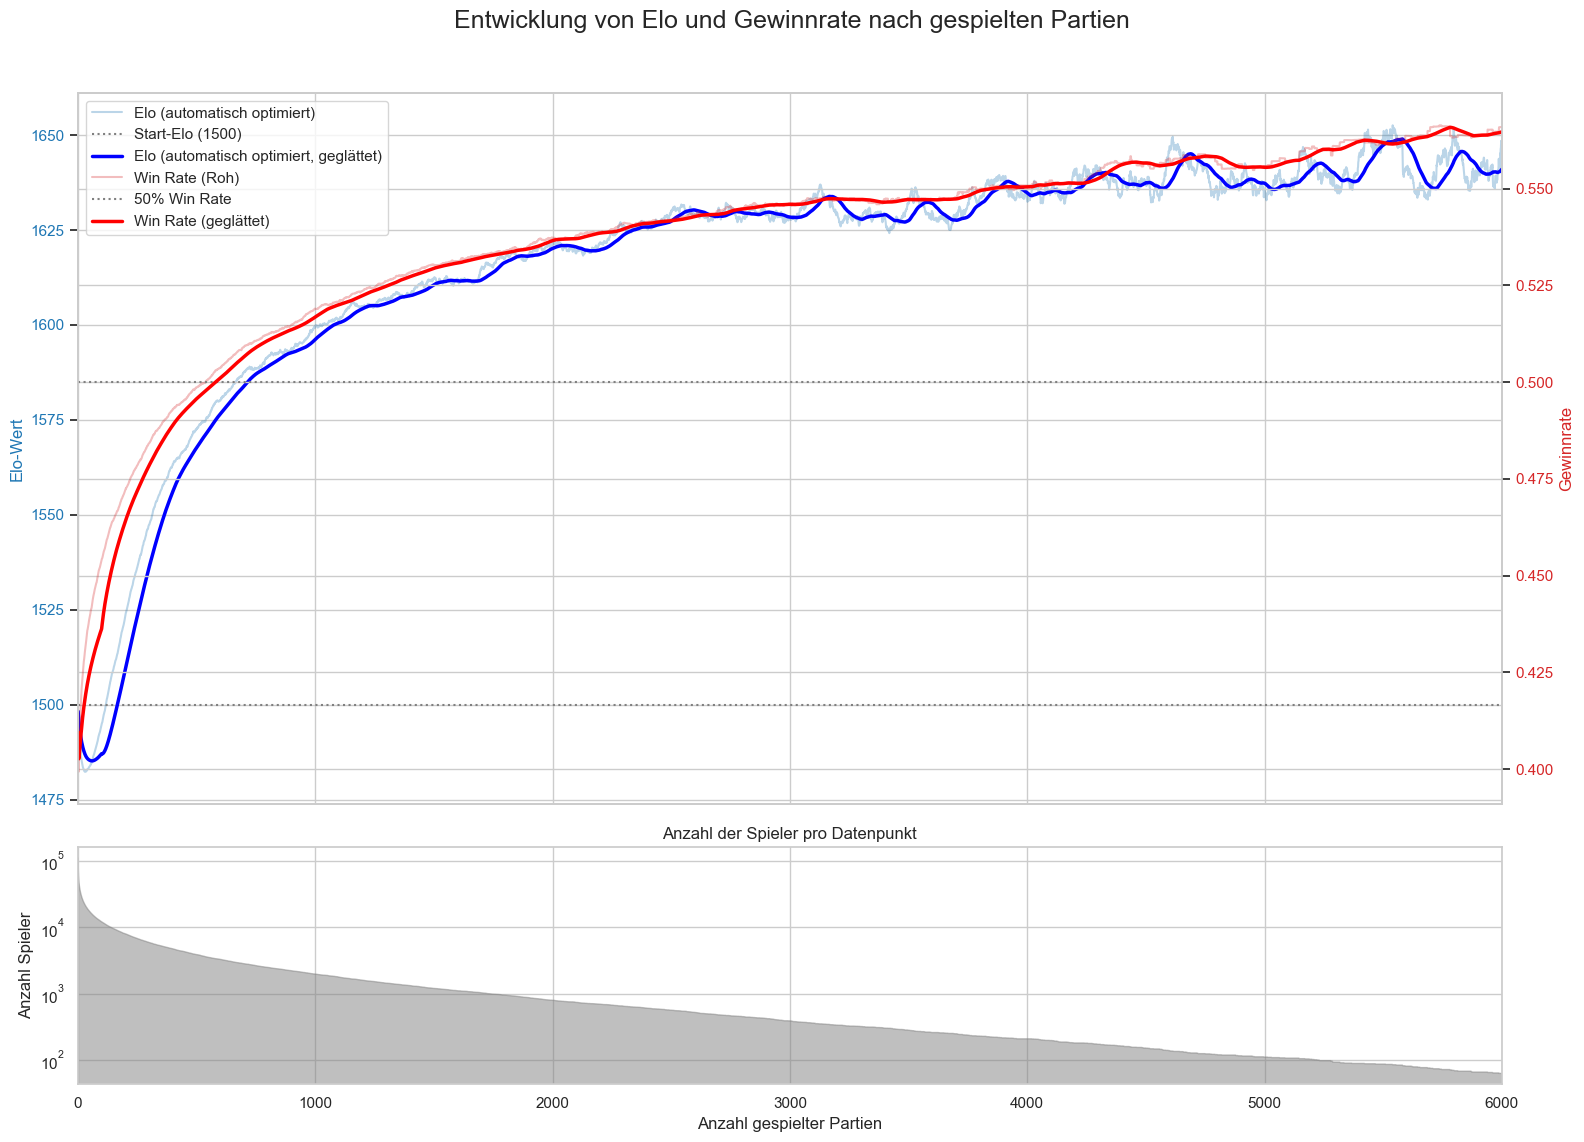

In [116]:
params_00 = {
    'divisor': 402.0,
    'k_newbie': 23.1,
    'k_standard': 13.7,
    'k_expert': 10.0,
    'newbie_threshold_games': 30,
    'expert_threshold_elo': 2400.0,
    'start_elo': 1500.0,
}

timeseries_df_00 = generate_timeseries(params_00, df_all)
aggregated_df_00 = aggregate_timeseries(timeseries_df_00)
plot_timeseries(aggregated_df_00, 'automatisch optimiert')

### 5.5.2 Bereich anpassen

Ausgangsparameter sind die Werte wie beim Schach. Ich habe Start-Elo und Divisor durch ausprobieren so angepasst, dass die kleinste Elo-Zahl bei 1000 und die höchste bei 2400 liegt.

* Der Gelegenheitsspieler (Elo 1400 - 1600) soll zwischen 100 und 200 Partien liegen.
* Der Durchschnittsspieler (Elo 1600 - 1800) soll zwischen 200 und 500 Partien liegen.

Simuliere Spielverlauf: 100%|██████████| 2160767/2160767 [05:50<00:00, 6158.35 Partien/s]


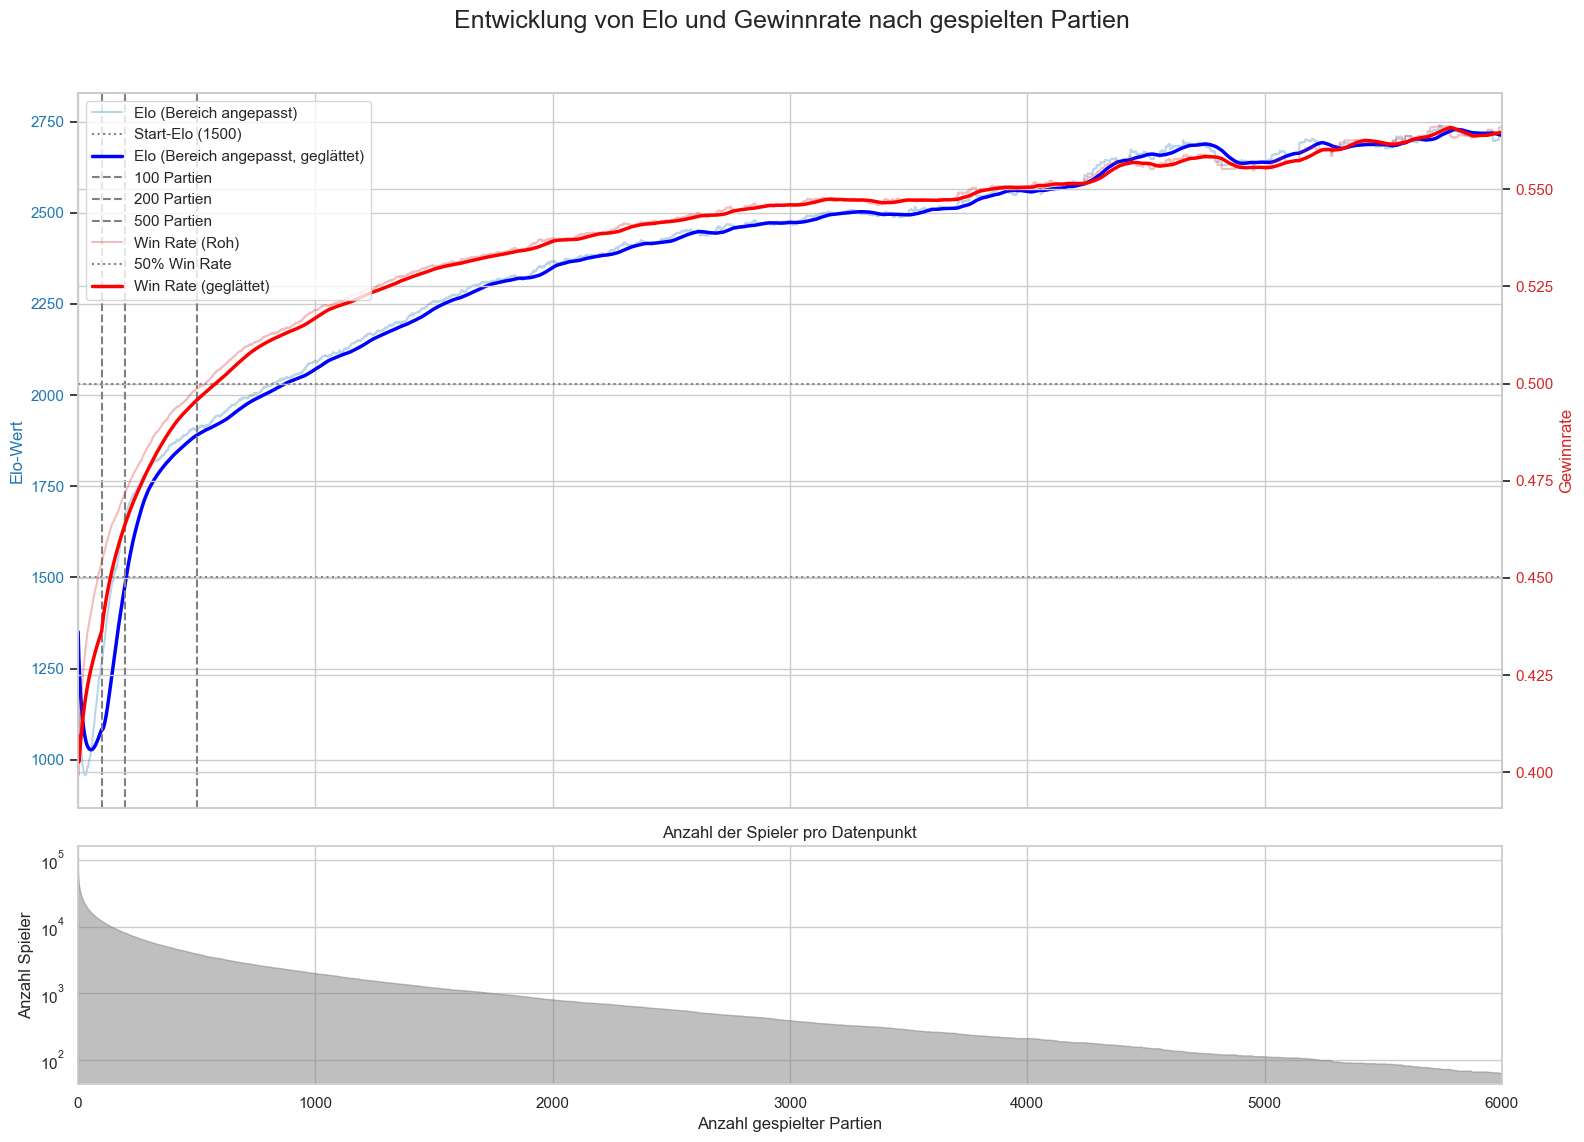

In [138]:
params_01 = {
    'divisor': 5000.0, # geändert von 400
    'k_newbie': 600, # geändert von 40
    'k_standard': 20.0,
    'k_expert': 10.0,
    'newbie_threshold_games': 200, # geändert vom 30
    'expert_threshold_elo': 2400.0,
    'start_elo': 1400.0,  # geändert von 1500
}

timeseries_df_01 = generate_timeseries(params_01, df_all)
aggregated_df_01 = aggregate_timeseries(timeseries_df_01)
plot_timeseries(aggregated_df_01, 'Bereich angepasst')

Simuliere Spielverlauf: 100%|██████████| 2160767/2160767 [06:09<00:00, 5841.78 Partien/s]


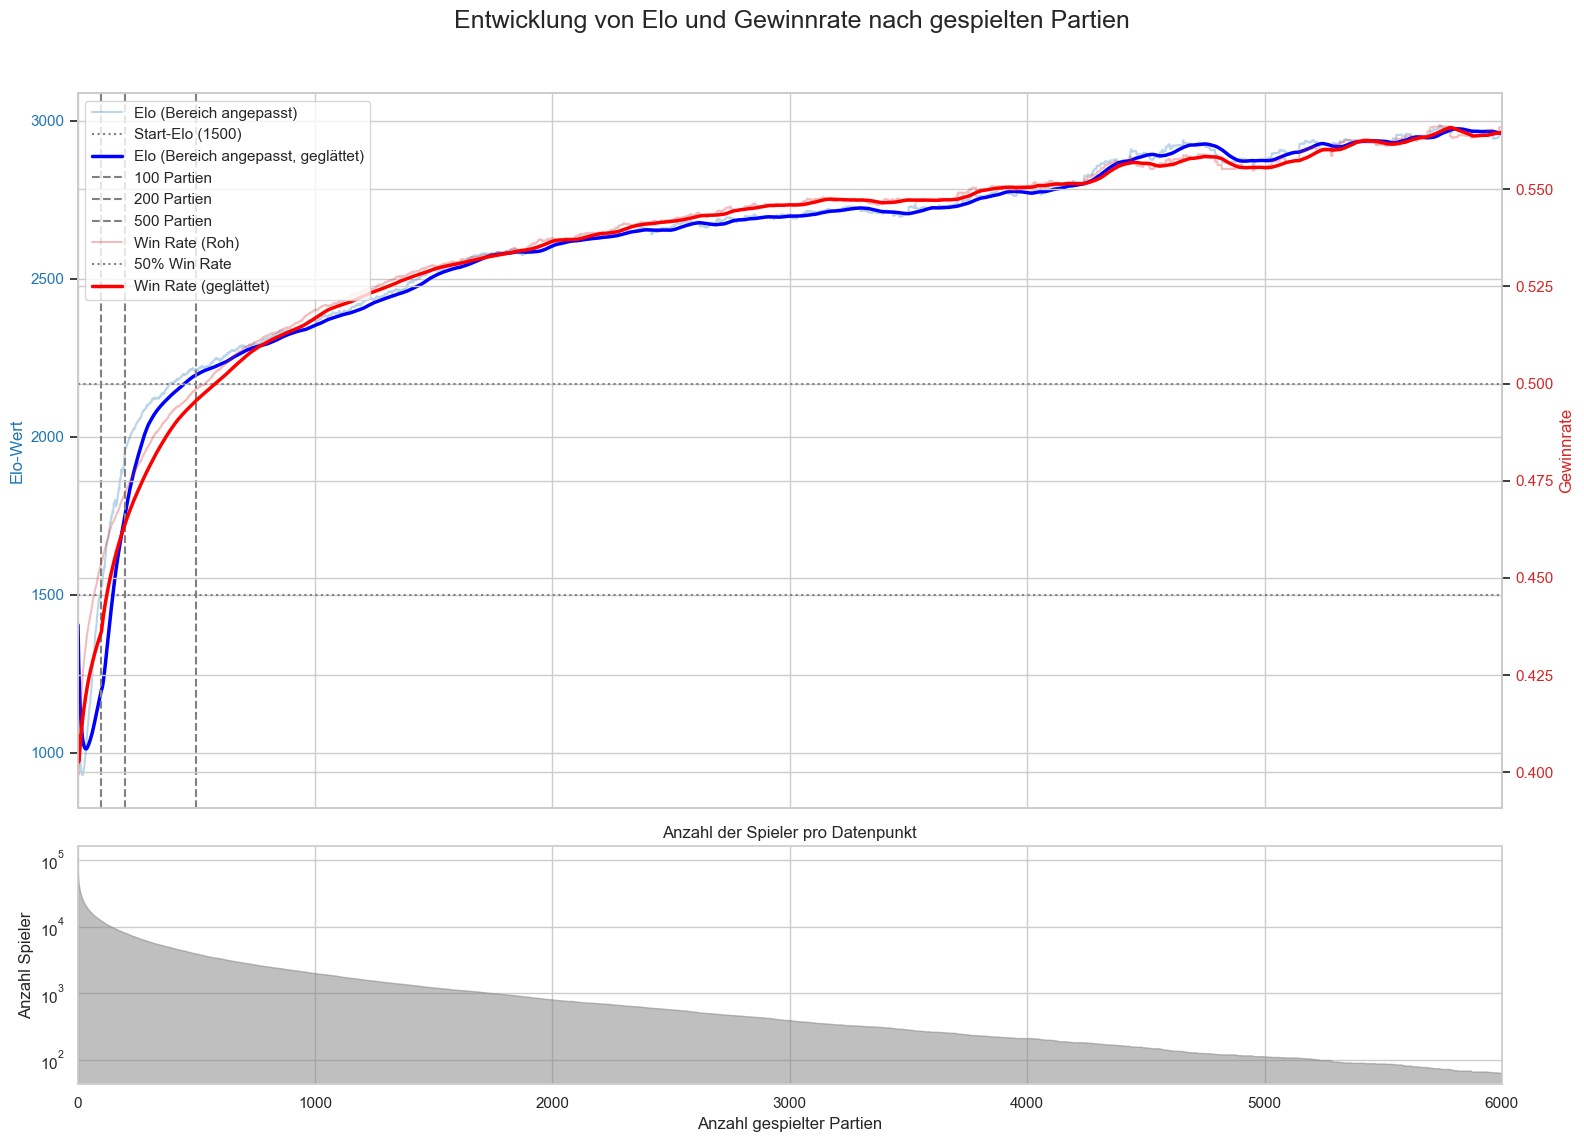

In [143]:
params_01 = {
    'divisor': 5000.0, # geändert von 400
    'k_newbie': 1200, # geändert von 40
    'k_standard': 20.0,
    'k_expert': 10.0,
    'newbie_threshold_games': 200, # geändert vom 30
    'expert_threshold_elo': 2400.0,
    'start_elo': 1500.0,  # geändert von 1500
}

timeseries_df_01 = generate_timeseries(params_01, df_all)
aggregated_df_01 = aggregate_timeseries(timeseries_df_01)
plot_timeseries(aggregated_df_01, 'Bereich angepasst')

### 5.5.3 Experte anpassen

Der Expert soll zwischen 200 und 500 Partien liegen.

In [86]:
params_02 = {
    'divisor': 2950.0,
    'k_newbie': 80.0, # geändert von 100
    'k_standard': 20.0,
    'k_expert': 5.0,  # geändert von 10
    'newbie_threshold_games': 1000, # geändert von 100
    'expert_threshold_elo': 1750.0, # geändert von 2400
    'start_elo': 1050.0,
}

timeseries_df_02 = generate_timeseries(params_02, df_all)
aggregated_df_02 = aggregate_timeseries(timeseries_df_02)
plot_timeseries(aggregated_df_02, 'Mitte angepasst')


Starte die Simulation zur Erstellung der Zeitreihen-Daten...


Simuliere Spielverlauf: 100%|██████████| 2160767/2160767 [05:32<00:00, 6497.62 Partien/s]


Simulation abgeschlossen.


,player_id,num_games,elo_value,win_rate
0,1,1,1090.0,1.0
1,2,1,1010.0,0.0
2,3,1,1090.0,1.0
3,4,1,1010.0,0.0
4,9,1,1090.0,1.0



Aggregiere die Zeitreihen-Daten...
Aggregation abgeschlossen.


,num_games,player_count,avg_win_rate,avg_elo_value
0,1,111107,0.409470,1044.099644
1,2,70909,0.399822,1037.607920
2,3,58002,0.399285,1032.052721
3,4,51153,0.402005,1027.536180
4,5,46704,0.404548,1023.520372


### 5.5.4 Ende anpassen

In [92]:
params_03 = {
    'divisor': 2950.0,  # geändert von 3000
    'k_newbie': 80.0, # beim nächsten Versuch auf 100
    'k_standard': 20.0, # beim nächsten Versuch auf 18
    'k_expert': 5.0,
    'newbie_threshold_games': 550, # geändert von 1000
    'expert_threshold_elo': 1750.0,
    'start_elo': 1050.0,
}

timeseries_df_03 = generate_timeseries(params_03, df_all)
aggregated_df_03 = aggregate_timeseries(timeseries_df_03)
plot_timeseries(aggregated_df_03, 'Ende angepasst')


Starte die Simulation zur Erstellung der Zeitreihen-Daten...


Simuliere Spielverlauf: 100%|██████████| 2160767/2160767 [05:50<00:00, 6158.63 Partien/s]


Simulation abgeschlossen.


,player_id,num_games,elo_value,win_rate
0,1,1,1040.0,1.0
1,2,1,960.0,0.0
2,3,1,1040.0,1.0
3,4,1,960.0,0.0
4,9,1,1040.0,1.0



Aggregiere die Zeitreihen-Daten...
Aggregation abgeschlossen.


,num_games,player_count,avg_win_rate,avg_elo_value
0,1,111107,0.409470,993.972514
1,2,70909,0.399822,987.320368
2,3,58002,0.399285,981.600788
3,4,51153,0.402005,976.931922
4,5,46704,0.404548,972.746396


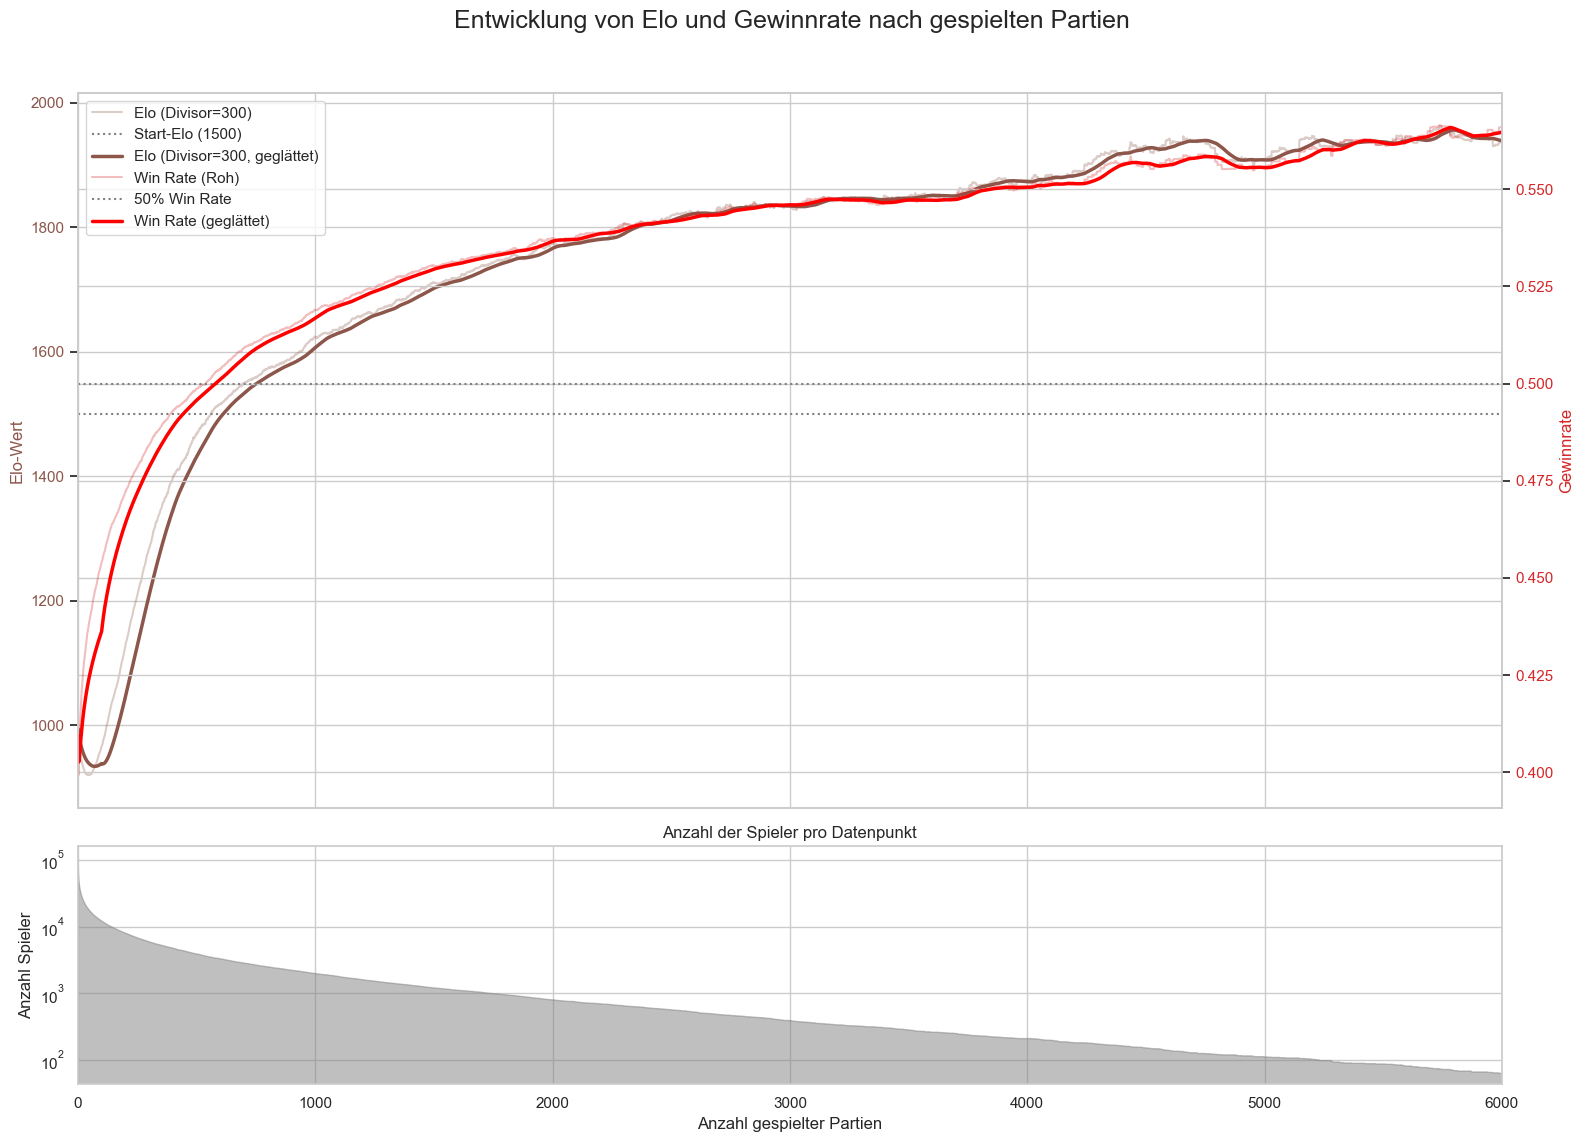

In [93]:
# Plotten

import matplotlib.pyplot as plt
import seaborn as sns

# Beschränke die Daten auf den zu plottenden Bereich für bessere Lesbarkeit
MAX_GAMES_TO_PLOT = 6000
plot_df = aggregated_df_divisor_300[aggregated_df_divisor_300['num_games'] <= MAX_GAMES_TO_PLOT].copy()

# Matplotlib Stil setzen
sns.set_theme(style="whitegrid")
#plt.rcParams['figure.figsize'] = (16, 8) # Etwas breiter für die x-Achse

# Erstelle eine Figur mit zwei untereinander liegenden Subplots
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(16, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.suptitle('Entwicklung von Elo und Gewinnrate nach gespielten Partien', fontsize=18)

# Plot 1: Elo und Win Rate (obere Grafik)
color1 = 'tab:brown'
ax1.set_ylabel('Elo-Wert', color=color1, fontsize=12)
sns.lineplot(x='num_games', y='avg_elo_value', data=plot_df, ax=ax1, color=color1, alpha=0.3, label='Elo (Divisor=300)')
ax1.axhline(1500, color='gray', linestyle=':', label='Start-Elo (1500)')
ax1.tick_params(axis='y', labelcolor=color1)

# Glättung mit gleitendem Durchschnitt
window_size = 100
plot_df['elo_moving_avg'] = plot_df['avg_elo_value'].rolling(window=window_size, min_periods=1).mean()
sns.lineplot(x='num_games', y='elo_moving_avg', data=plot_df, ax=ax1, color=color1, linewidth=2.5, label=f'Elo (Divisor=300, geglättet)')

# Rechte Y-Achse für Win Rate
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Gewinnrate', color=color2, fontsize=12)
sns.lineplot(x='num_games', y='avg_win_rate', data=plot_df, ax=ax2, color=color2, alpha=0.3, label='Win Rate (Roh)')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.axhline(0.5, color='gray', linestyle=':', label='50% Win Rate')

# Glättung für Win Rate
plot_df['win_rate_moving_avg'] = plot_df['avg_win_rate'].rolling(window=window_size, min_periods=1).mean()
sns.lineplot(x='num_games', y='win_rate_moving_avg', data=plot_df, ax=ax2, color='red', linewidth=2.5, label=f'Win Rate (geglättet)')

ax1.grid(True)

# KORRIGIERTE LEGENDEN-LOGIK

# Sammle Handles und Labels von beiden Achsen manuell
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Kombiniere sie und erstelle eine einzige Legende auf der ZWEITEN Achse
ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper left')  # ax2 ist "oben" und überschreibt nichts.

# Entferne die automatisch generierte Legende von der ersten Achse, falls vorhanden
if ax1.get_legend() is not None:
    ax1.get_legend().remove()

# Plot 2: Anzahl der Spieler pro Datenpunkt (untere Grafik)
ax3.set_xlabel('Anzahl gespielter Partien', fontsize=12)
ax3.set_ylabel('Anzahl Spieler', fontsize=12)
ax3.fill_between(plot_df['num_games'], plot_df['player_count'], color='gray', alpha=0.5)
ax3.set_yscale('log')
ax3.set_title('Anzahl der Spieler pro Datenpunkt', fontsize=12)
ax3.grid(True)

# Setze das X-Achsen-Limit NACHDEM alle Daten geplottet wurden
ax1.set_xlim(0, MAX_GAMES_TO_PLOT)

# Layout anpassen
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

plt.show()


### 5.5.4 Alle zusammen

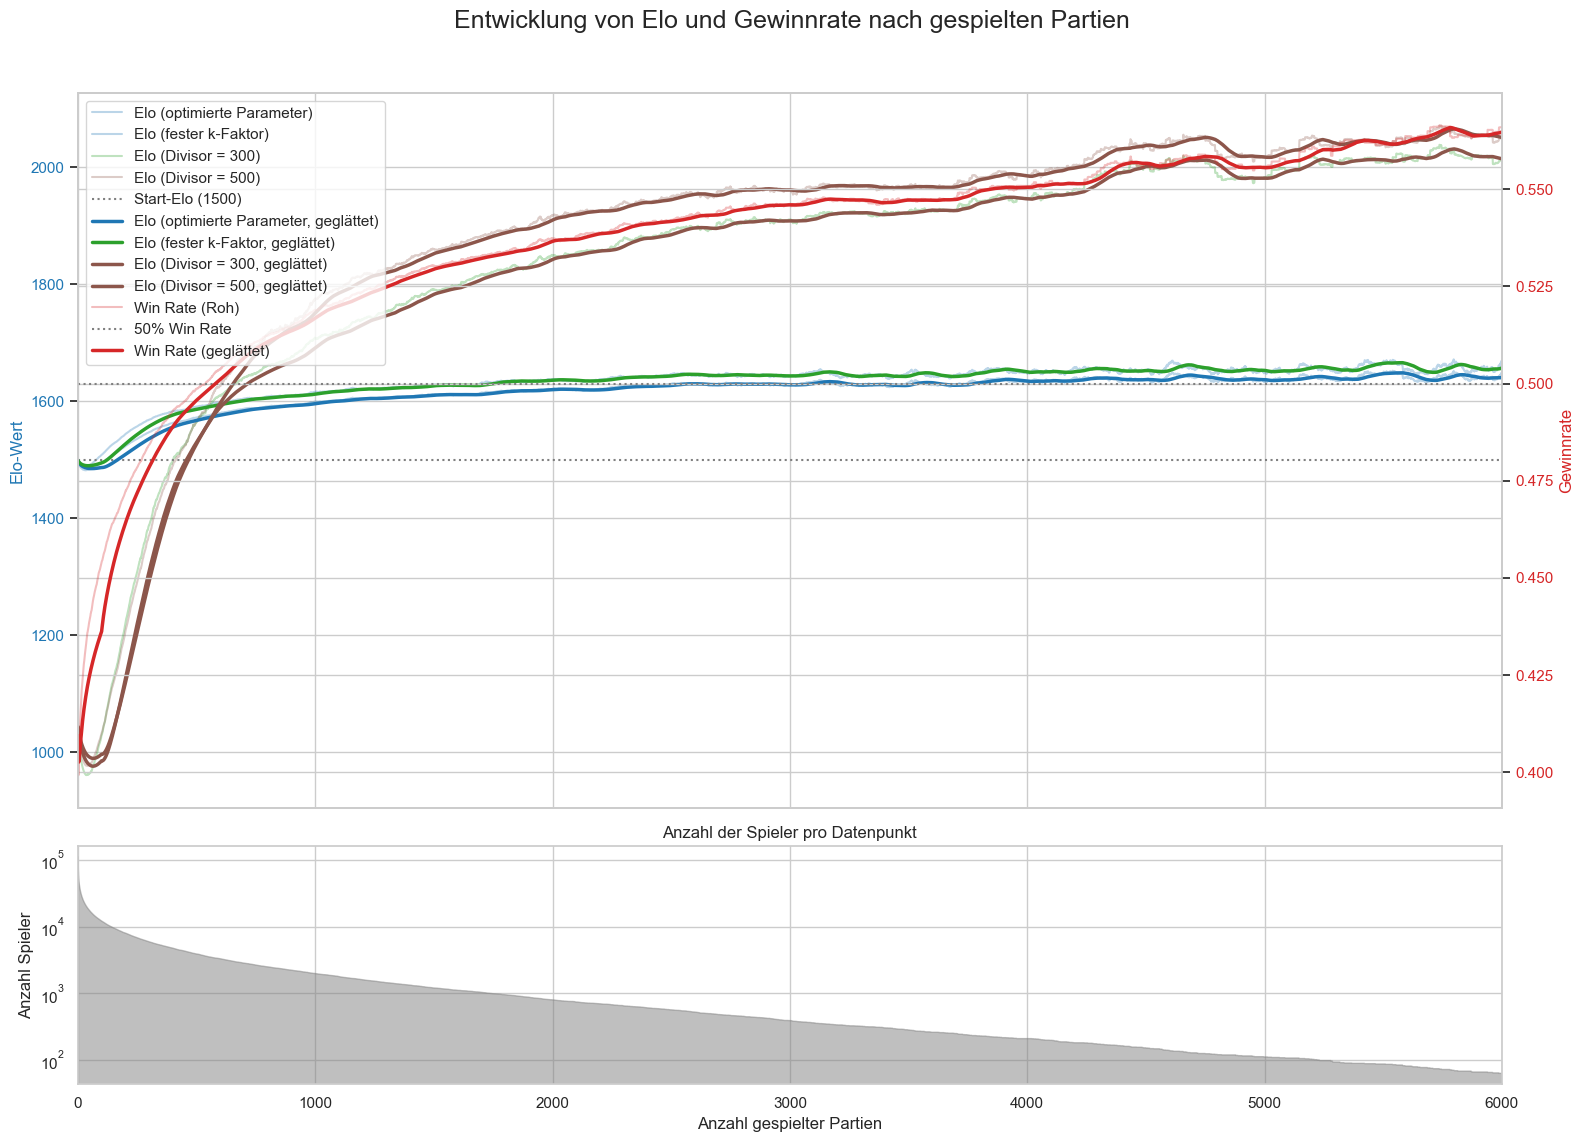

In [91]:
# Plotten

import matplotlib.pyplot as plt
import seaborn as sns

# Beschränke die Daten auf den zu plottenden Bereich für bessere Lesbarkeit
MAX_GAMES_TO_PLOT = 6000
plot_df_00 = aggregated_df_00[aggregated_df_00['num_games'] <= MAX_GAMES_TO_PLOT].copy()
plot_df_01 = aggregated_df_01[aggregated_df_01['num_games'] <= MAX_GAMES_TO_PLOT].copy()
plot_df_02 = aggregated_df_02[aggregated_df_02['num_games'] <= MAX_GAMES_TO_PLOT].copy()
plot_df_03 = aggregated_df_03[aggregated_df_03['num_games'] <= MAX_GAMES_TO_PLOT].copy()

# Matplotlib Stil setzen
sns.set_theme(style="whitegrid")
#plt.rcParams['figure.figsize'] = (16, 8) # Etwas breiter für die x-Achse

# Erstelle eine Figur mit zwei untereinander liegenden Subplots
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(16, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.suptitle('Entwicklung von Elo und Gewinnrate nach gespielten Partien', fontsize=18)

# Plot 1: Elo und Win Rate (obere Grafik)
color0 = 'tab:white'
color1 = 'tab:blue'
color2 = 'tab:green'
color3 = 'tab:brown'
ax1.set_ylabel('Elo-Wert', color=color1, fontsize=12)
sns.lineplot(x='num_games', y='avg_elo_value', data=plot_df_00, ax=ax1, color=color0, alpha=0.3, label='Elo (optimierte Parameter)')
sns.lineplot(x='num_games', y='avg_elo_value', data=plot_df_01, ax=ax1, color=color1, alpha=0.3, label='Elo (Start angepasst)')
sns.lineplot(x='num_games', y='avg_elo_value', data=plot_df_02, ax=ax1, color=color2, alpha=0.3, label='Elo (Mitte angepasst)')
sns.lineplot(x='num_games', y='avg_elo_value', data=plot_df_03, ax=ax1, color=color3, alpha=0.3, label='Elo (Ende angepasst)')
ax1.axhline(1500, color='gray', linestyle=':', label='Start-Elo (1500)')
ax1.tick_params(axis='y', labelcolor=color1)

# Glättung mit gleitendem Durchschnitt
window_size = 100
plot_df_00['elo_moving_avg'] = plot_df_00['avg_elo_value'].rolling(window=window_size, min_periods=1).mean()
sns.lineplot(x='num_games', y='elo_moving_avg', data=plot_df_00, ax=ax1, color=color0, linewidth=2.5, label=f'Elo (optimierte Parameter, geglättet)')
plot_df_01['elo_moving_avg'] = plot_df_01['avg_elo_value'].rolling(window=window_size, min_periods=1).mean()
sns.lineplot(x='num_games', y='elo_moving_avg', data=plot_df_01, ax=ax1, color=color1, linewidth=2.5, label=f'Elo (Start angepasst), geglättet)')
plot_df_02['elo_moving_avg'] = plot_df_02['avg_elo_value'].rolling(window=window_size, min_periods=1).mean()
sns.lineplot(x='num_games', y='elo_moving_avg', data=plot_df_02, ax=ax1, color=color2, linewidth=2.5, label=f'Elo (Mittel angepasst, geglättet)')
plot_df_03['elo_moving_avg'] = plot_df_03['avg_elo_value'].rolling(window=window_size, min_periods=1).mean()
sns.lineplot(x='num_games', y='elo_moving_avg', data=plot_df_03, ax=ax1, color=color3, linewidth=2.5, label=f'Elo (Ende angepasst, geglättet)')

# Rechte Y-Achse für Win Rate
ax2 = ax1.twinx()
color0 = 'tab:red'
ax2.set_ylabel('Gewinnrate', color=color0, fontsize=12)
sns.lineplot(x='num_games', y='avg_win_rate', data=plot_df, ax=ax2, color=color0, alpha=0.3, label='Win Rate (Roh)')
ax2.tick_params(axis='y', labelcolor=color0)
ax2.axhline(0.5, color='gray', linestyle=':', label='50% Win Rate')

# Glättung für Win Rate
plot_df['win_rate_moving_avg'] = plot_df['avg_win_rate'].rolling(window=window_size, min_periods=1).mean()
sns.lineplot(x='num_games', y='win_rate_moving_avg', data=plot_df, ax=ax2, color=color0, linewidth=2.5, label=f'Win Rate (geglättet)')

ax1.grid(True)

# KORRIGIERTE LEGENDEN-LOGIK

# Sammle Handles und Labels von beiden Achsen manuell
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Kombiniere sie und erstelle eine einzige Legende auf der ZWEITEN Achse
ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper left')  # ax2 ist "oben" und überschreibt nichts.

# Entferne die automatisch generierte Legende von der ersten Achse, falls vorhanden
if ax1.get_legend() is not None:
    ax1.get_legend().remove()

# Plot 2: Anzahl der Spieler pro Datenpunkt (untere Grafik)
ax3.set_xlabel('Anzahl gespielter Partien', fontsize=12)
ax3.set_ylabel('Anzahl Spieler', fontsize=12)
ax3.fill_between(plot_df['num_games'], plot_df['player_count'], color='gray', alpha=0.5)
ax3.set_yscale('log')
ax3.set_title('Anzahl der Spieler pro Datenpunkt', fontsize=12)
ax3.grid(True)

# Setze das X-Achsen-Limit NACHDEM alle Daten geplottet wurden
ax1.set_xlim(0, MAX_GAMES_TO_PLOT)

# Layout anpassen
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

plt.show()


## 5.6 Spieler-Selektion

**Fragestellung:** Wo ziehen wir die Grenze für "gute Spieler"?

**Entscheidung**

TODO
Basierend auf diesem Diagramm können wir einen fundierten Schwellenwert festlegen. Z.B. "Wir nehmen alle Spieler mit elo_final >= 1700", was vielleicht die Top 20% der Spielerbasis darstellt.

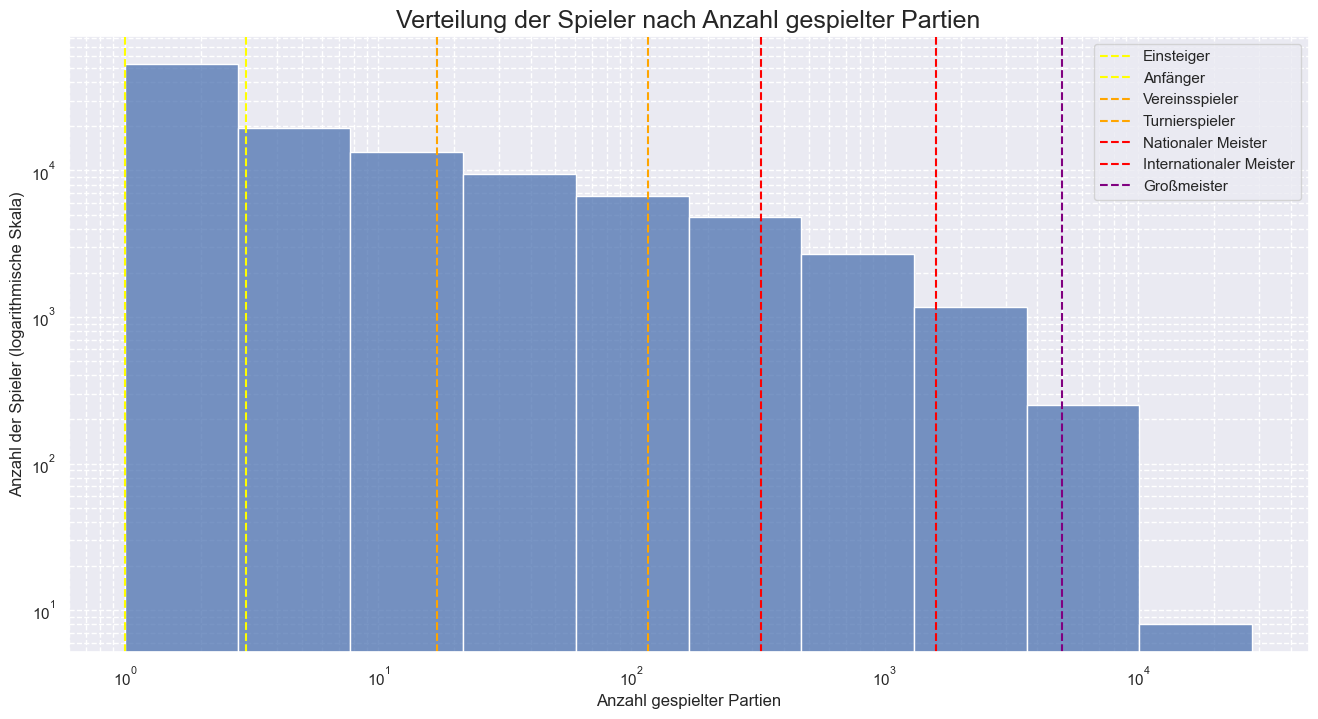


Die unteren 5% der Spieler haben <= 1 Partien gespielt.
Die oberen 5% der Spieler haben >= 324 Partien gespielt.


In [81]:
# Visualisierung als Histogramm (Balkendiagramm)
plt.figure(figsize=(16, 8))

# Wir verwenden ein Histogramm, um die Spieler in Erfahrungs-Bins zu gruppieren.
# Die logarithmische Skala auf beiden Achsen hilft, die extreme Verteilung darzustellen.
ax = sns.histplot(data=player_exp_df, x='num_games', log_scale=True,  bins=10) # x-Achse logarithmisch
ax.set_yscale('log')  # y-Achse logarithmisch

plt.title(f'Verteilung der Spieler nach Anzahl gespielter Partien', fontsize=18)
plt.xlabel('Anzahl gespielter Partien', fontsize=12)
plt.ylabel('Anzahl der Spieler (logarithmische Skala)', fontsize=12)
plt.grid(True, which="both", ls="--")

# Füge vertikale Linien für die Schach-Elo-Kategorien hinzu (angenommene Spieleanzahl)
# Diese Schwellen sind Hypothesen!
plt.axvline(1, color='yellow', linestyle='--', label='Einsteiger')
plt.axvline(3, color='yellow', linestyle='--', label='Anfänger')
plt.axvline(17, color='orange', linestyle='--', label='Vereinsspieler')
plt.axvline(116, color='orange', linestyle='--', label='Turnierspieler')
plt.axvline(324, color='red', linestyle='--', label='Nationaler Meister')
plt.axvline(1595, color='red', linestyle='--', label='Internationaler Meister')
plt.axvline(4992, color='purple', linestyle='--', label='Großmeister')
plt.legend()

plt.show()

# Wir können nun unsere Ziel-Elos an die Perzentile der Spielerfahrung koppeln
p5_games = player_exp_df['num_games'].quantile(0.05)
p95_games = player_exp_df['num_games'].quantile(0.95)
print(f"\nDie unteren 5% der Spieler haben <= {p5_games:.0f} Partien gespielt.")
print(f"Die oberen 5% der Spieler haben >= {p95_games:.0f} Partien gespielt.")

**Interpretation**

Dies zeigt uns die Verteilung der Spielstärke im Datensatz. Wir sehen, wo die Mehrheit der Spieler liegt und wie viele "Experten" (z.B. Elo > 2000) es gibt.